# Backend Execution

*What you will learn:*

- what a `Backend` is for;
- what types of emulator `Backend` exist;
- how to choose the best `Backend` for your needs;
- how to execute a `Sequence` on an emulator `Backend` and retrieve the results.
- what changes when you want to submit on the QPU

## Introduction

When the time comes to execute a Pulser sequence, there are many options: one can choose to execute it on a QPU or on an emulator, which might happen locally or remotely. All these options are accessible through an unified interface we call a `Backend`. 

**This tutorial is a step-by-step guide on how to use emulator backends for Pulser sequence execution.**

Although the final goal of a quantum algorithm is to run on a QPU, we always recommend starting on an emulator. Emulators are more readily available, and at lower cost, in addition to providing much more information than a QPU, which can only measure bitstrings. When running on an emulator we recommend first doing some exploratory runs locally to ensure you're doing the right thing, before submitting your heavier jobs to be run on the cluster through the cloud.

## 1. Creating the Pulse Sequence
The first step is to create the sequence that we want to execute. Here, we make a sequence by combining a Blackman waveform in amplitude and a ramp in detuning. Since it will be executed on an emulator, we can create the register we want and choose an appropriate `Device`.

In [1]:
import numpy as np
import pulser
import pulser_simulation

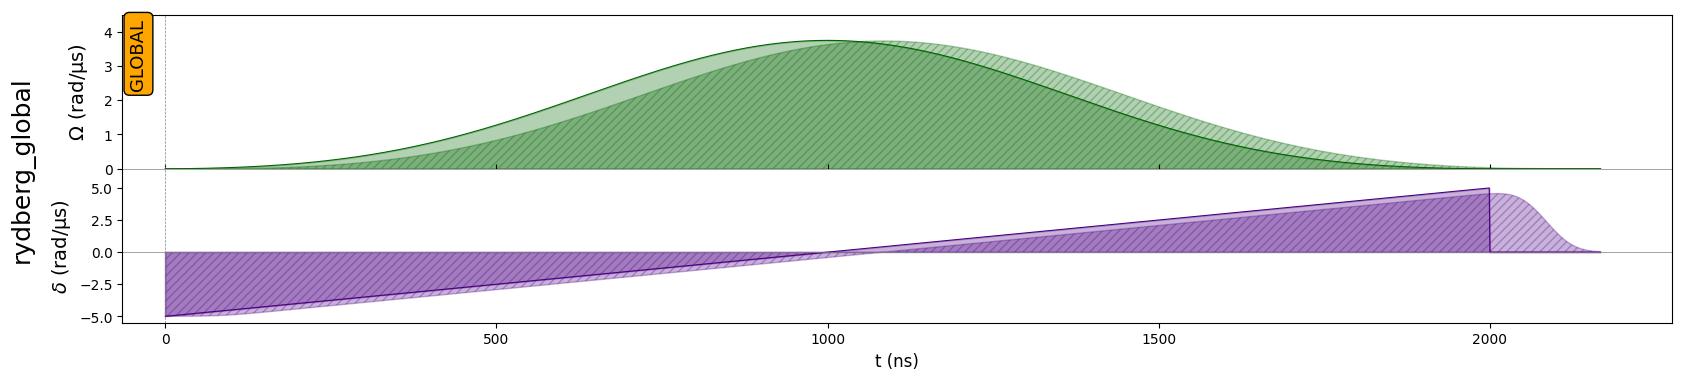

In [2]:
reg = pulser.Register({"q0": (-5, 0), "q1": (5, 0)})

seq = pulser.Sequence(reg, pulser.AnalogDevice)
seq.declare_channel("rydberg_global", "rydberg_global")
t = 2000  # ns

amp_wf = pulser.BlackmanWaveform(t, np.pi)
det_wf = pulser.RampWaveform(t, -5, 5)
seq.add(pulser.Pulse(amp_wf, det_wf, 0), "rydberg_global")

seq.draw()

## 2. Running on a local backend
It is now time to select and initialize the backend. We will start running things locally using the `QutipBackendV2` (from `pulser_simulation`). It uses `qutip` to emulate the sequence execution locally.

Keep in mind that other emulators are available, and the full list is available [here](../apidoc/_autosummary/pulser.backends.rst#module-pulser.backends).

<div class="alert alert-info">
You can acess all backends that are available on your system via the `pulser.backends` module so you don't need to explicitly import them.
</div>
Upon creation, all backends require the sequence they will execute. 

<div class="alert alert-info">

By default, all backends return the bitstrings at the final time, and `QutipBackendV2` also returns the final state.
</div>

In [3]:
qutip_bknd = pulser.backends.QutipBackendV2(seq)
qutip_results = qutip_bknd.run()

## 3. Retrieving the Results

<div class="alert alert-info">

Info

For more details on how to extract values from `Results`, consult [this page](../results.ipynb#Accessing-Results).
</div>

For any `Results` returned from an `EmulatorBackend`, we can query the contents of a result. As we can see below, `QutipBackendV2` returns the bitstrings and quantum state at the final time. 

<div class="alert alert-info">

Note that the times at which a result is measured are presented as a fraction of the sequence duration, so a time of `1.0` always represent the final time.
</div>

In [4]:
print(qutip_results)

Results
-------
Stored results: ['bitstrings', 'state']
Evaluation times per result: {'bitstrings': [1.0], 'state': [1.0]}
Atom order in states and bitstrings: ('q0', 'q1')
Total sequence duration: 2000 ns


We can query the bitstrings at the final time, if present, using a dedicated property.

In [5]:
print(qutip_results.final_bitstrings)

Counter({'11': 949, '10': 26, '01': 22, '00': 3})


The same is true for the final state.

In [6]:
print(qutip_results.final_state)

QutipState
----------
Eigenstates: ('r', 'g')
Quantum object: dims=[[2, 2], [1]], shape=(4, 1), type='ket', dtype=Dense
Qobj data =
[[ 0.62161132+0.75098248j]
 [-0.03357887+0.14524584j]
 [-0.03357887+0.14524584j]
 [-0.00110516-0.07194168j]]


All results of a specific type can also be accessed through the name returned in `get_result_tags()`. Notice that this will return a list of each result of that type, at each time it was measured. The corresponding measurement times are returned by `get_result_times()`.

In [7]:
print("Stored results' tags:", qutip_results.get_result_tags())
print("Evaluation times for 'bitstrings':", qutip_results.get_result_times("bitstrings"))
# These are equivalent
qutip_results.get_result("bitstrings", 1.0)
qutip_results.bitstrings[-1]

Stored results' tags: ['bitstrings', 'state']
Evaluation times for 'bitstrings': [1.0]


Counter({'11': 944, '10': 29, '01': 25, '00': 2})

## 4. Configuring the Backend
Emulator backends also accept, optionally, a configuration given as an instance of the `EmulationConfig` class. As can be seen from the [docs](../apidoc/_autosummary/pulser.backend.EmulationConfig.rst), this class defines a few generally applicable configuration options, and then accepts backend specific options as keyword arguments. Each backend defines a subclass of `EmulationConfig`, such as `QutipConfig` for `QutipBackendV2`, that makes explicit the specific options for that backend. Since we are not interested in changing configuration options specific to `QutipBackendV2`, we use the `EmulationConfig` class directly.

To showcase the flexibility of emulation backends specifically, we will configure `QutipBackendV2` to return the overlap with the Bell state halfway through the sequence and at the end, which can be done using the `Fidelity` observable documented [here](../apidoc/_autosummary/pulser.backend.Fidelity.rst). 

The additional observables available by default are documented [here](../apidoc/_autosummary/pulser.backend.rst).

<div class="alert alert-info">

A `Fidelity` observable is normally added to the `Results` as `fidelity`, but in order to make it more specific, we use `tag_suffix` to make it present itself as `fidelity_bell`. This option is present for all observables, but it mostly makes sense for observable types that could show up multiple times with different parameters.
</div>

<div class="alert alert-warning">

When passing a `State` or `Operator` to an observable, or when passing the `initial_state` to an `EmulationConfig`, it is important to pass the type of object associated to the backend in question. Which types these are can be found in the subclass of `EmulationConfig` associated to that backend.
</div>

<div class="alert alert-info">

The specific subclass of `EmulationConfig` that is associated with each backend can be found in the documentation for that backend class (e.g. [here](../apidoc/_autosummary/pulser_simulation.QutipBackendV2.rst) for `QutipBackendV2`).
</div>

In [8]:
fidelity_state = pulser_simulation.QutipState.from_state_amplitudes(
    eigenstates=("r", "g"),
    amplitudes={"rr": 1 / np.sqrt(2), "gg": 1 / np.sqrt(2)},
)
fidelity = pulser.backend.Fidelity(
    state=fidelity_state, tag_suffix="bell", evaluation_times=[0.5, 1.0]
)

config = pulser.backend.EmulationConfig(
    observables=[fidelity],
)

Now that we have defined a config, we can create a new backend, run the emulation, and analyze the results.

In [9]:
qutip_bknd_custom = pulser.backends.QutipBackendV2(seq, config=config)
custom_results = qutip_bknd_custom.run()

Since we requested the fidelity at two different times, asking for the result times will reflect this.

In [10]:
print(custom_results.get_result_tags())
print(custom_results.get_result_times("fidelity_bell"))

['fidelity_bell']
[0.5, 1.0]


The two fidelities are in the results in chronological order.

In [11]:
print(custom_results.fidelity_bell[0])
print(custom_results.fidelity_bell[1])

0.07682093627900612
0.42306198747321244


## 5. Running Remotely

Now that we understand the behaviour of our sequence, and how to use emulator backends locally, let's run the sequence on a pair of remote backends

- `EmuFreeBackendV2` (from `pulser_pasqal`): Executes the sequence on `QutipBackendV2`, but runs remotely in the cloud. 
- `EmuMPSBackend` (from `pulser_pasqal`): Executes the sequence on `MPSBackend` but runs remotely in the cloud.

A full list of available backends is available in the [backends' docstrings](../apidoc/_autosummary/pulser.backends.rst#module-pulser.backends).

Notice that running things remotely in the cloud requires us to specify login credentials through a `RemoteConnection` object. The appropriate connection object for running through the Pasqal cloud is as follows:

In [ ]:
from pulser_pasqal import PasqalCloud

connection = PasqalCloud(
    username=USERNAME,  # Your username or email address for the Pasqal Cloud Platform
    project_id=PROJECT_ID,  # The ID of the project associated to your account
    password=PASSWORD,  # The password for your Pasqal Cloud Platform account
)

We now have a connection to the cloud. However, before creating the backends, let us create a custom `EmulationConfig` with a `Fidelity` observable again. A user running remotely cannot be expected to have each `Backend` available in the cloud installed locally. To compensate for this fact, specifying a `Fidelity` observable for use remotely can be done using a generic `State` type appropriate for all remote backends.

<div class="alert alert-info">

When passing a `State` or `Operator` to an observable for remote use, or when passing the `initial_state` to `EmulationConfig`, it is recommended to use the `StateRepr` and `OperatorRepr` classes, which will work for all remote backends but not for local ones.
</div>

<div class="alert alert-warning">

When running remotely, the configuration and emulation results have to be serialized. Since quantum states are potentially extremely large, the `StateResult` observable is disabled, and `State` and `Operator` classes will only serialize if they were created from an abstract representation.
</div>

In [13]:
remote_fidelity_state = pulser.backend.StateRepr.from_state_amplitudes(
    eigenstates=("r", "g"),
    amplitudes={"rr": 1 / np.sqrt(2), "gg": 1 / np.sqrt(2)},
)
remote_fidelity = pulser.backend.Fidelity(
    state=remote_fidelity_state, tag_suffix="bell", evaluation_times=[0.5, 1.0]
)

remote_config = pulser.backend.EmulationConfig(
    observables=[remote_fidelity],
)

Now that we have a proper `Sequence`, `EmulationConfig` and `Connection`, we can create the `EmuFreeBackendV2` and `EmuMPSBackend` with which we want to run the emulation.

In [14]:
free_bknd = pulser.backends.EmuFreeBackendV2(
    seq, config=remote_config, connection=connection
)
mps_bknd = pulser.backends.EmuMPSBackend(
    seq, config=remote_config, connection=connection
)

For a local `Backend`, the `run` method takes no arguments, but for cloud, it is required to pass a `job_params`. Inside `job_params` the number of `runs` must be specified for legacy reasons. Since the value will be ignored in our current case, we will put `runs=1`.

In [15]:
# Remote execution, requires job_params
job_params = [{"runs": 1}]
free_results = free_bknd.run(job_params=job_params)
mps_results = mps_bknd.run(job_params=job_params)

For remote backends, the object returned is a `RemoteResults` instance, which uses the connection to fetch the results once they are ready. To check the status of the batch, we can run:

In [17]:
print(free_results.get_batch_status())
print(mps_results.get_batch_status())

BatchStatus.DONE
BatchStatus.DONE


When the batch states shows as `DONE`, the results can be accessed. They are packaged in a `RemoteResults` objects, which will contain one `Results` for each entry in `job_params` in the same order. We can use `get_available_results` to see the results as they become available.

In [18]:
free_results.get_available_results()

{'d6e6e73e-88d5-4b58-81d2-e291cbe16493': Results(atom_order=('q0', 'q1'), total_duration=2000, _results={UUID('1158fa1a-a268-4abe-95c2-246a656e1a68'): [0.07682093627900612, 0.42306198747321244]}, _times={UUID('1158fa1a-a268-4abe-95c2-246a656e1a68'): [0.5, 1.0]}, _aggregation_methods={UUID('1158fa1a-a268-4abe-95c2-246a656e1a68'): <AggregationMethod.MEAN: 2>}, _tagmap={'fidelity_bell': UUID('1158fa1a-a268-4abe-95c2-246a656e1a68')})}

We can see that there is only one `Results` object in the list after the job is done since only a single item was present in `job_params` above. Note that since we ran the same sequence as locally, the fidelity is the same as in that case.

In [19]:
print(free_results[-1].fidelity_bell[0])
print(free_results[-1].fidelity_bell[1])

0.07682093627900612
0.42306198747321244


In addition to the above, `MPSBackend`, `SVBackend` and their derivatives, such as the remote `EmuMPSBackend` store runtime `statistics` in the `Results`. For more information about this, please see the corresponding [documentation](https://pasqal-io.github.io/emulators/latest/observables/).

In [20]:
print(mps_results[-1].get_result_tags())
print(mps_results[-1].fidelity_bell[0])
print(mps_results[-1].fidelity_bell[1])

['statistics', 'fidelity_bell']
0.07685184646911727
0.4228824148514162


## 6. Differences when running on a QPU

Sequence execution on a QPU is done through the `QPUBackend`, which is a remote backend. Therefore, it requires a `RemoteConnection`, which should be open from the start due to two additional QPU constraints:

1. The `Device` must be chosen among the options available at the moment, which can be found through `connection.fetch_available_devices()`.
2. If in the chosen device `Device.requires_layout` is `True`, the `Register` must be defined from a register layout:  
    -  If `Device.accepts_new_layouts` is `False`, use one of the register layouts calibrated for the chosen `Device` (found under `Device.calibrated_register_layouts`). Check out [this tutorial](reg_layouts.nblink) for more information on how to define a `Register` from a `RegisterLayout`.
    - Otherwise, we may choose to define our own custom layout or rely on `Register.with_automatic_layout()` to
    give us a register from an automatically generated register layout that fits our desired register while obeying the device constraints. 

## 7. Alternative user interfaces for using remote backends

Once you have created a Pulser sequence, you can also use specialized Python SDKs to send it for execution:

- the [pasqal-cloud](https://docs.pasqal.cloud/cloud/pasqal-cloud/) Python SDK, developed by PASQAL and used under-the-hood by Pulser's remote backends.
- Azure's Quantum Development Kit (QDK) which you can use by creating an [Azure Quantum workspace](https://learn.microsoft.com/en-gb/azure/quantum/provider-pasqal) directly integrated with PASQAL emulators and QPU.